# ***DESI Human Glioma Section Spectra Clinical State Classification***

This notebook shows the process of section spectra clinical state classification of the DESI Human Glioma preprocessed dataset.

### ***Import packages***

Before we begin, let"s import all the necessary packages for this notebook.
First we add the directory which has our python files:

In [1]:
import sys
sys.path.insert(0, "../..")

Next we import all the necessary packages for this notebook:

In [2]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let"s define some constant variables for this notebook:

In [3]:
# Define folder that contains the dhg dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dhg dataset
DHG_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains dhg clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 50
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "s"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 1.5 

### ***Reading MSI clinical state anotations***

Next, lets read the clinical state anotations for each MSI:

In [4]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all tissue spectra from all MSI:***

Next, let"s get all informations except intensities (which need a lot of memory) for each tissue spectra from all MSI:

In [5]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep sample file name of spectra
        file_names.append(msi_row.file_name)
        # Keep sample number of spectra
        sample_numbers.append(msi_row.sample_number)
        # Keep sample histology of spectra
        histologies.append(msi_row.histology)
        # Keep sample who grade of spectra
        who_grades.append(msi_row.who_grade)
        # Keep x coordinate of spectra
        x_coordinates.append(x)
        # Keep y coordinate of spectra
        y_coordinates.append(y)
        # Keep  of spectra
        idxs.append(idx)

# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:03<00:00,  5.15s/it]


### ***MSI parsers opening:***

Next, let"s create parser for each MSI in order to read spectra's for the model:

In [6]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DHG_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

### ***Dataset generator:***

Next, let"s create a dataset generator for the model:

In [7]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let"s create a classification dense neural network model:

In [8]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dense(512, activation='relu'),
      layers.Dense(512, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***LOOCV Classification:***

Next, let"s apply classification using LOOCV for best evaluation:

In [9]:
# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data
  train_filter = (sample_numbers != exclude_sample)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  training_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)
  test_generator = create_ds(indexes[~train_filter], BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_accuracy",
      mode="max",
      save_best_only=True)
  
  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(
      monitor='val_loss', mode='min', verbose=1, patience=5, min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(
      optimizer, loss=losses.BinaryCrossentropy(), metrics=["accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=training_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved 
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute the classification model on test set
  test_eval = classification_model.evaluate(x=test_generator)

  # Clean model for next iteration
  classification_model = None

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/50
84/84 [==============================] - 19s 212ms/step - loss: 0.4842 - accuracy: 0.7522 - val_loss: 0.1255 - val_accuracy: 0.9755
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/50
84/84 [==============================] - 20s 241ms/step - loss: 0.0345 - accuracy: 0.9907 - val_loss: 0.0153 - val_accuracy: 0.9942
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 3/50
84/84 [==============================] - 19s 219ms/step - loss: 0.0984 - accuracy: 0.9712 - val_loss: 0.0780 - val_accuracy: 0.9766
Epoch 4/50
84/84 [==============================] - 18s 211ms/step - loss: 0.0350 - accuracy: 0.9893 - val_loss: 0.0110 - val_accuracy: 0.9964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 5/50
84/84 [==============================] - 18s 218ms/step - loss: 0.0028 - accuracy

  5%|▍         | 1/22 [06:18<2:12:32, 378.67s/it]

Epoch 1/50
83/83 [==============================] - 19s 221ms/step - loss: 0.5115 - accuracy: 0.7249 - val_loss: 0.2134 - val_accuracy: 0.9217
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/50
83/83 [==============================] - 18s 219ms/step - loss: 0.0999 - accuracy: 0.9652 - val_loss: 0.0186 - val_accuracy: 0.9938
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 3/50
83/83 [==============================] - 19s 227ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0058 - val_accuracy: 0.9979
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 4/50
83/83 [==============================] - 19s 225ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0367 - val_accuracy: 0.9875
Epoch 5/50
83/83 [==============================] - 18s 219ms/step - loss: 9.2077e-04 - accu

  9%|▉         | 2/22 [09:57<1:34:55, 284.80s/it]

Epoch 1/50
83/83 [==============================] - 19s 229ms/step - loss: 0.4757 - accuracy: 0.7532 - val_loss: 0.2159 - val_accuracy: 0.9199
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/50
83/83 [==============================] - 18s 221ms/step - loss: 0.1164 - accuracy: 0.9602 - val_loss: 0.0498 - val_accuracy: 0.9864
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 3/50
83/83 [==============================] - 19s 225ms/step - loss: 0.0193 - accuracy: 0.9934 - val_loss: 0.3730 - val_accuracy: 0.8743
Epoch 4/50
83/83 [==============================] - 19s 228ms/step - loss: 0.0195 - accuracy: 0.9929 - val_loss: 0.0098 - val_accuracy: 0.9960
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 5/50
83/83 [==============================] - 19s 230ms/step - loss: 0.0011 - accuracy

 14%|█▎        | 3/22 [13:57<1:23:41, 264.26s/it]

Epoch 1/50
84/84 [==============================] - 22s 258ms/step - loss: 0.4836 - accuracy: 0.7484 - val_loss: 0.2220 - val_accuracy: 0.9190
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/50
84/84 [==============================] - 20s 233ms/step - loss: 0.1385 - accuracy: 0.9528 - val_loss: 0.0972 - val_accuracy: 0.9697
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 3/50
84/84 [==============================] - 19s 231ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 0.0124 - val_accuracy: 0.9944
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 4/50
84/84 [==============================] - 19s 231ms/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0026 - val_accuracy: 0.9993
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_model

 18%|█▊        | 4/22 [17:09<1:10:40, 235.60s/it]

Epoch 1/50
84/84 [==============================] - 19s 224ms/step - loss: 0.4739 - accuracy: 0.7552 - val_loss: 0.1996 - val_accuracy: 0.9296
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/50
84/84 [==============================] - 18s 216ms/step - loss: 0.1134 - accuracy: 0.9627 - val_loss: 0.0211 - val_accuracy: 0.9916
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 3/50
84/84 [==============================] - 19s 225ms/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0123 - val_accuracy: 0.9951
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 4/50
84/84 [==============================] - 18s 217ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9991
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_model

 23%|██▎       | 5/22 [20:12<1:01:22, 216.61s/it]

Epoch 1/50
84/84 [==============================] - 19s 226ms/step - loss: 0.5092 - accuracy: 0.7316 - val_loss: 0.2244 - val_accuracy: 0.9166
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/50
84/84 [==============================] - 21s 243ms/step - loss: 0.1512 - accuracy: 0.9483 - val_loss: 0.0797 - val_accuracy: 0.9656
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 3/50
84/84 [==============================] - 21s 247ms/step - loss: 0.0130 - accuracy: 0.9955 - val_loss: 0.0062 - val_accuracy: 0.9972
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 4/50
84/84 [==============================] - 19s 222ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0042 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_model

 27%|██▋       | 6/22 [24:01<58:55, 220.97s/it]  

Epoch 1/50
79/79 [==============================] - 19s 239ms/step - loss: 0.5033 - accuracy: 0.7416 - val_loss: 0.1865 - val_accuracy: 0.9444
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/50
79/79 [==============================] - 19s 239ms/step - loss: 0.0457 - accuracy: 0.9855 - val_loss: 0.0126 - val_accuracy: 0.9956
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 3/50
79/79 [==============================] - 20s 252ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0102 - val_accuracy: 0.9964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 4/50
79/79 [==============================] - 18s 229ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0126 - val_accuracy: 0.9956
Epoch 5/50
79/79 [==============================] - 19s 241ms/step - loss: 0.0023 - accuracy

 32%|███▏      | 7/22 [27:38<54:56, 219.76s/it]

Epoch 1/50
84/84 [==============================] - 21s 239ms/step - loss: 0.5196 - accuracy: 0.7166 - val_loss: 0.2394 - val_accuracy: 0.9189
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/50
84/84 [==============================] - 20s 233ms/step - loss: 0.1812 - accuracy: 0.9364 - val_loss: 0.1108 - val_accuracy: 0.9600
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 3/50
84/84 [==============================] - 21s 252ms/step - loss: 0.0245 - accuracy: 0.9931 - val_loss: 0.0152 - val_accuracy: 0.9946
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 4/50
84/84 [==============================] - 20s 236ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0097 - val_accuracy: 0.9968
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_model

 36%|███▋      | 8/22 [31:51<53:42, 230.20s/it]

Epoch 1/50
83/83 [==============================] - 21s 255ms/step - loss: 0.4917 - accuracy: 0.7381 - val_loss: 0.2072 - val_accuracy: 0.9234
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/50
83/83 [==============================] - 22s 257ms/step - loss: 0.1017 - accuracy: 0.9660 - val_loss: 0.0113 - val_accuracy: 0.9964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 3/50
83/83 [==============================] - 19s 228ms/step - loss: 0.0076 - accuracy: 0.9975 - val_loss: 0.0064 - val_accuracy: 0.9975
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 4/50
83/83 [==============================] - 19s 228ms/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0044 - val_accuracy: 0.9985
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_mo

 41%|████      | 9/22 [36:01<51:12, 236.31s/it]

Epoch 1/50
81/81 [==============================] - 19s 231ms/step - loss: 0.5149 - accuracy: 0.7244 - val_loss: 0.2745 - val_accuracy: 0.9052
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/50
81/81 [==============================] - 18s 227ms/step - loss: 0.1573 - accuracy: 0.9451 - val_loss: 0.0266 - val_accuracy: 0.9918
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 3/50
81/81 [==============================] - 20s 240ms/step - loss: 0.0587 - accuracy: 0.9813 - val_loss: 0.0430 - val_accuracy: 0.9865
Epoch 4/50
81/81 [==============================] - 19s 235ms/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0069 - val_accuracy: 0.9975
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 5/50
81/81 [==============================] - 20s 241ms/step - loss: 0.0021 - accur

 45%|████▌     | 10/22 [40:42<50:02, 250.21s/it]

Epoch 1/50
78/78 [==============================] - 20s 252ms/step - loss: 0.5676 - accuracy: 0.6899 - val_loss: 0.3265 - val_accuracy: 0.9149
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/50
78/78 [==============================] - 18s 234ms/step - loss: 0.1530 - accuracy: 0.9559 - val_loss: 0.0490 - val_accuracy: 0.9865
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 3/50
78/78 [==============================] - 18s 227ms/step - loss: 0.0180 - accuracy: 0.9952 - val_loss: 0.0110 - val_accuracy: 0.9962
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 4/50
78/78 [==============================] - 18s 226ms/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0067 - val_accuracy: 0.9978
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_mo

 50%|█████     | 11/22 [45:18<47:17, 257.99s/it]

Epoch 1/50
82/82 [==============================] - 21s 248ms/step - loss: 0.4960 - accuracy: 0.7484 - val_loss: 0.2452 - val_accuracy: 0.9212
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/50
82/82 [==============================] - 20s 247ms/step - loss: 0.0501 - accuracy: 0.9858 - val_loss: 0.0085 - val_accuracy: 0.9966
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 3/50
82/82 [==============================] - 21s 249ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.0038 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 4/50
82/82 [==============================] - 21s 254ms/step - loss: 0.0013 - accuracy: 0.9998 - val_loss: 0.0022 - val_accuracy: 0.9989
Epoch 5/50
82/82 [==============================] - 19s 237ms/step - loss: 3.9839e-04 - a

 55%|█████▍    | 12/22 [49:28<42:35, 255.55s/it]

Epoch 1/50
80/80 [==============================] - 21s 253ms/step - loss: 0.5542 - accuracy: 0.6852 - val_loss: 0.3119 - val_accuracy: 0.9180
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/50
80/80 [==============================] - 20s 253ms/step - loss: 0.2230 - accuracy: 0.9267 - val_loss: 0.1404 - val_accuracy: 0.9479
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 3/50
80/80 [==============================] - 19s 233ms/step - loss: 0.0365 - accuracy: 0.9884 - val_loss: 0.0135 - val_accuracy: 0.9959
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 4/50
80/80 [==============================] - 20s 246ms/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0158 - val_accuracy: 0.9939
Epoch 5/50
80/80 [==============================] - 19s 241ms/step - loss: 0.0028 - accur

 59%|█████▉    | 13/22 [53:10<36:48, 245.35s/it]

Epoch 1/50
82/82 [==============================] - 20s 238ms/step - loss: 0.5082 - accuracy: 0.7264 - val_loss: 0.2297 - val_accuracy: 0.9306
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/50
82/82 [==============================] - 20s 242ms/step - loss: 0.1877 - accuracy: 0.9349 - val_loss: 0.1778 - val_accuracy: 0.9353
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 3/50
82/82 [==============================] - 19s 224ms/step - loss: 0.1176 - accuracy: 0.9401 - val_loss: 0.0646 - val_accuracy: 0.9349
Epoch 4/50
82/82 [==============================] - 19s 234ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0096 - val_accuracy: 0.9977
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 5/50
82/82 [==============================] - 20s 237ms/step - loss: 0.0030 - accur

 64%|██████▎   | 14/22 [57:39<33:41, 252.65s/it]

Epoch 1/50
82/82 [==============================] - 19s 233ms/step - loss: 0.5160 - accuracy: 0.7265 - val_loss: 0.2344 - val_accuracy: 0.9170
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/50
82/82 [==============================] - 19s 224ms/step - loss: 0.1658 - accuracy: 0.9403 - val_loss: 0.0815 - val_accuracy: 0.9664
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 3/50
82/82 [==============================] - 18s 222ms/step - loss: 0.0230 - accuracy: 0.9925 - val_loss: 0.0138 - val_accuracy: 0.9956
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 4/50
82/82 [==============================] - 20s 242ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0343 - val_accuracy: 0.9889
Epoch 5/50
82/82 [==============================] - 20s 245ms/step - loss: 7.4006e-04 - a

 68%|██████▊   | 15/22 [1:01:48<29:20, 251.47s/it]

Epoch 1/50
83/83 [==============================] - 21s 250ms/step - loss: 0.5119 - accuracy: 0.7273 - val_loss: 0.2171 - val_accuracy: 0.9176
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/50
83/83 [==============================] - 20s 241ms/step - loss: 0.1294 - accuracy: 0.9554 - val_loss: 0.0284 - val_accuracy: 0.9907
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 3/50
83/83 [==============================] - 20s 238ms/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0305 - val_accuracy: 0.9886
Epoch 4/50
83/83 [==============================] - 19s 232ms/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0135 - val_accuracy: 0.9966
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 5/50
83/83 [==============================] - 20s 240ms/step - loss: 9.8681e-04 - a

 73%|███████▎  | 16/22 [1:05:43<24:40, 246.73s/it]

Epoch 1/50
84/84 [==============================] - 21s 246ms/step - loss: 0.5051 - accuracy: 0.7361 - val_loss: 0.2785 - val_accuracy: 0.8979
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/50
84/84 [==============================] - 20s 234ms/step - loss: 0.1819 - accuracy: 0.9357 - val_loss: 0.0719 - val_accuracy: 0.9792
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 3/50
84/84 [==============================] - 20s 241ms/step - loss: 0.0217 - accuracy: 0.9935 - val_loss: 0.0081 - val_accuracy: 0.9964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 4/50
84/84 [==============================] - 21s 245ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0070 - val_accuracy: 0.9972
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_mo

 77%|███████▋  | 17/22 [1:09:16<19:42, 236.43s/it]

Epoch 1/50
82/82 [==============================] - 21s 248ms/step - loss: 0.4989 - accuracy: 0.7427 - val_loss: 0.1954 - val_accuracy: 0.9264
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/50
82/82 [==============================] - 21s 249ms/step - loss: 0.0755 - accuracy: 0.9742 - val_loss: 0.0239 - val_accuracy: 0.9914
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 3/50
82/82 [==============================] - 20s 242ms/step - loss: 0.0040 - accuracy: 0.9987 - val_loss: 0.0047 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 4/50
82/82 [==============================] - 21s 258ms/step - loss: 0.0472 - accuracy: 0.9866 - val_loss: 0.0107 - val_accuracy: 0.9962
Epoch 5/50
82/82 [==============================] - 19s 236ms/step - loss: 0.0014 - accur

 82%|████████▏ | 18/22 [1:17:07<20:27, 306.80s/it]

Epoch 1/50
81/81 [==============================] - 21s 250ms/step - loss: 0.4556 - accuracy: 0.7668 - val_loss: 0.1583 - val_accuracy: 0.9496
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/50
81/81 [==============================] - 19s 231ms/step - loss: 0.0649 - accuracy: 0.9806 - val_loss: 0.0059 - val_accuracy: 0.9979
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 3/50
81/81 [==============================] - 19s 231ms/step - loss: 0.0067 - accuracy: 0.9983 - val_loss: 0.0021 - val_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 4/50
81/81 [==============================] - 20s 244ms/step - loss: 5.6272e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9992
Epoch 5/50
81/81 [==============================] - 18s 220ms/step - loss: 7.3329e-05

 86%|████████▋ | 19/22 [1:20:08<13:27, 269.27s/it]

Epoch 1/50
81/81 [==============================] - 21s 250ms/step - loss: 0.5258 - accuracy: 0.7326 - val_loss: 0.2764 - val_accuracy: 0.9448
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/50
81/81 [==============================] - 21s 255ms/step - loss: 0.0858 - accuracy: 0.9768 - val_loss: 0.0221 - val_accuracy: 0.9917
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 3/50
81/81 [==============================] - 19s 227ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0052 - val_accuracy: 0.9983
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 4/50
81/81 [==============================] - 19s 228ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0038 - val_accuracy: 0.9983
Epoch 5/50
81/81 [==============================] - 20s 243ms/step - loss: 4.6780e-04 - a

 91%|█████████ | 20/22 [1:24:55<09:08, 274.44s/it]

Epoch 1/50
82/82 [==============================] - 20s 241ms/step - loss: 0.5100 - accuracy: 0.7315 - val_loss: 0.2395 - val_accuracy: 0.9085
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/50
82/82 [==============================] - 19s 237ms/step - loss: 0.1737 - accuracy: 0.9374 - val_loss: 0.0616 - val_accuracy: 0.9834
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 3/50
82/82 [==============================] - 19s 235ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0066 - val_accuracy: 0.9977
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 4/50
82/82 [==============================] - 21s 252ms/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 0.0091 - val_accuracy: 0.9969
Epoch 5/50
82/82 [==============================] - 20s 246ms/step - loss: 3.7195e-04 - a

 95%|█████████▌| 21/22 [1:28:26<04:15, 255.41s/it]

Epoch 1/50
79/79 [==============================] - 19s 240ms/step - loss: 0.5007 - accuracy: 0.7376 - val_loss: 0.2570 - val_accuracy: 0.9208
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/50
79/79 [==============================] - 19s 235ms/step - loss: 0.1041 - accuracy: 0.9658 - val_loss: 0.0111 - val_accuracy: 0.9958
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 3/50
79/79 [==============================] - 19s 235ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0070 - val_accuracy: 0.9978
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 4/50
79/79 [==============================] - 19s 240ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0054 - val_accuracy: 0.9982
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_mo

100%|██████████| 22/22 [1:31:50<00:00, 250.46s/it]


### ***LOOCV predictions:***

Next, let"s get predictions for each LOOCV for evaluation:

In [10]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  train_filter = (sample_numbers != exclude_sample)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[~train_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = (who_grades[~train_filter] > 2).astype(int)

  # Clean model for next iteration
  classification_model = None

 27%|██▋       | 6/22 [00:15<00:39,  2.47s/it]

100%|██████████| 22/22 [01:07<00:00,  3.05s/it]


### ***Roc curve:***

Next, let"s plot LOOCV roc curve:

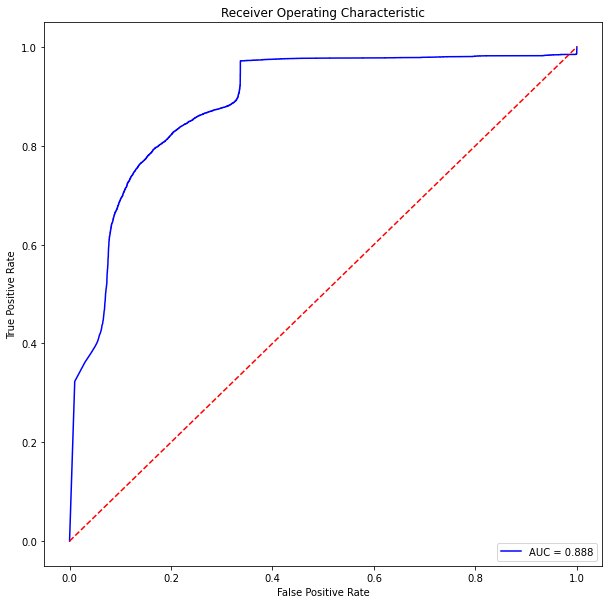

In [11]:
fpr, tpr, thresholds = metrics.roc_curve(
  np.concatenate(list(true_labels.values())),
  np.concatenate(list(predictions.values())))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, "b", label = f"AUC = {roc_auc:.3f}")
plt.legend(loc = "lower right")
plt.plot([0, 1], [0, 1],"r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [12]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()